In [66]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_score, plot_confusion_matrix
from matplotlib import pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
%matplotlib inline
import numpy as np
import pandas as pd
import pickle

In [6]:
# # Train/Test Split - Just run once
# X_tas = np.load('Data/tas_train.npy')
# X_psl = np.load('Data/psl_train.npy')
# y=np.load('Data/nao_index_train.npy')

# X = np.concatenate((X_tas, X_psl),axis=1)
# y=y.reshape(-1,1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# np.save('Data/train/X_train.npy', X_train)
# np.save('Data/test/X_test.npy', X_test)
# np.save('Data/train/y_train.npy', y_train)
# np.save('Data/test/y_test.npy', y_test)

# Exploratory Data Analysis

In [14]:
#Load training data
X_train = np.load('Data/train/X_train.npy')
y_train = np.load('Data/train/y_train.npy')
print(X_train.shape)
print(y_train.shape)

(720, 4644)
(720, 1)


In [20]:
# Data are standardized by column
X_df = pd.DataFrame(X_train)
print("Range of means: ",X_df.mean().max() - X_df.mean().min())
print("Range of stdevs: ",X_df.std().max() - X_df.std().min())

Range of means:  0.10698490791697654
Range of stdevs:  0.09475504033032955


In [11]:
# No missing data (synthetic dataset, so none are expected)
X_df.isna().sum().sum()

0

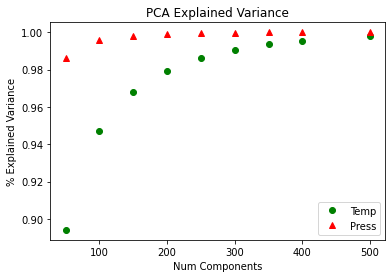

In [33]:
# PCA - Virtually all variance is explained in the first 200 PCs of press and the first 500 PCs of temp
num_components = [50,100,150,200,250,300,350,400,500]
explained_variance_temp = []
explained_variance_press = []
for i in num_components:
    pca_temp = PCA(n_components=i)
    pca_press = PCA(n_components=i)
    X_tas_pca = pca_temp.fit_transform(X_train[:,0:2321])
    X_psl_pca = pca_press.fit_transform(X_train[:,2322:4643])
    explained_variance_temp.append(pca_temp.explained_variance_ratio_.sum())
    explained_variance_press.append(pca_press.explained_variance_ratio_.sum())

    
plt.plot(num_components,explained_variance_temp,'go',label="Temp")
plt.plot(num_components,explained_variance_press,"r^",label="Press")
plt.title("PCA Explained Variance")
plt.xlabel("Num Components")
plt.ylabel("% Explained Variance")
plt.legend(loc="lower right")
plt.show()


(array([  1.,   1.,   0.,   3.,   7.,  13.,  34.,  32.,  54.,  60.,  81.,
         98., 100.,  88.,  75.,  38.,  23.,   8.,   3.,   1.]),
 array([-3.85065722, -3.51365315, -3.17664909, -2.83964502, -2.50264096,
        -2.16563689, -1.82863283, -1.49162876, -1.1546247 , -0.81762063,
        -0.48061657, -0.1436125 ,  0.19339157,  0.53039563,  0.8673997 ,
         1.20440376,  1.54140783,  1.87841189,  2.21541596,  2.55242002,
         2.88942409]),
 <BarContainer object of 20 artists>)

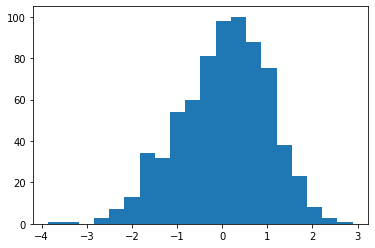

In [36]:
np.histogram(y_train, bins=20);
plt.hist(y_train,bins=20)

# Preprocessing

In [48]:
# Transform Training Data with PCA
pca_temp = PCA(n_components=500)
pca_press = PCA(n_components=200)
X_tas_pca = pca_temp.fit_transform(X_train[:,0:2321])
X_psl_pca = pca_press.fit_transform(X_train[:,2322:4643])
X_train_pca = np.concatenate((X_tas_pca,X_psl_pca),axis=1)

In [37]:
y_train_bin = np.sign(y_train).reshape(-1,)
# kbin = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
# kbin = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')

# y_train_cat= kbin.fit_transform(y_train.reshape(-1,1)).reshape(-1,)
# print(pd.Series(y_train_cat).value_counts())
# print(kbin.bin_edges_)

# Random Forest Classifier
## Binary Classification (positive or negative NAOI)

In [39]:
rf = RandomForestClassifier(random_state=1337)

In [42]:
# HPO without PCA
## Random Forest ##
parameters = {'max_depth':(10, 100), 'min_samples_split':[5, 15], 'criterion':['entropy','gini']}
clf = GridSearchCV(rf, parameters,scoring='f1_micro')
clf.fit(X_train,y_train_bin)
print(clf.best_score_)
print(clf.best_params_)

0.5430555555555555
{'criterion': 'gini', 'max_depth': 100, 'min_samples_split': 5}


Best Score: 0.5430555555555555

Best Params: {'criterion': 'gini', 'max_depth': 100, 'min_samples_split': 5}

In [46]:
results = pd.DataFrame(clf.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.943947,0.036387,0.015631,0.002286,entropy,10,5,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.576389,0.465278,0.576389,0.527778,0.493056,0.527778,0.044358,4
1,3.054767,0.091264,0.015892,0.001954,entropy,10,15,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.486111,0.500000,0.548611,0.520833,0.548611,0.520833,0.025230,5
2,3.417422,0.110275,0.018340,0.003511,entropy,100,5,"{'criterion': 'entropy', 'max_depth': 100, 'mi...",0.506944,0.479167,0.555556,0.493056,0.513889,0.509722,0.025835,8
3,3.281793,0.070005,0.017593,0.002014,entropy,100,15,"{'criterion': 'entropy', 'max_depth': 100, 'mi...",0.493056,0.506944,0.597222,0.534722,0.527778,0.531944,0.035843,3
4,1.832055,0.034881,0.014944,0.000756,gini,10,5,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.506944,0.520833,0.604167,0.513889,0.562500,0.541667,0.036747,2
5,1.786029,0.051446,0.015358,0.001015,gini,10,15,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.513889,0.472222,0.520833,0.541667,0.541667,0.518056,0.025459,6
6,2.020679,0.060403,0.016608,0.002780,gini,100,5,"{'criterion': 'gini', 'max_depth': 100, 'min_s...",0.500000,0.541667,0.562500,0.513889,0.597222,0.543056,0.034694,1
7,2.044202,0.081119,0.015634,0.002997,gini,100,15,"{'criterion': 'gini', 'max_depth': 100, 'min_s...",0.520833,0.451389,0.562500,0.500000,0.541667,0.515278,0.038138,7


In [49]:
# HPO with PCA
## Random Forest ##
parameters = {'max_depth':(10, 100), 'min_samples_split':[5, 15], 'criterion':['entropy','gini']}
clf = GridSearchCV(rf, parameters,scoring='f1_micro')
clf.fit(X_train_pca,y_train_bin)
print(clf.best_score_)
print(clf.best_params_)

0.548611111111111
{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}


Best Score: 0.548611111111111

Best Params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}

In [50]:
# Equal if not better performance when using PCA transform
results = pd.DataFrame(clf.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.200942,0.005981,0.014036,0.001604,entropy,10,5,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.534722,0.534722,0.541667,0.513889,0.576389,0.540278,0.020318,4
1,1.178871,0.018643,0.010775,0.000863,entropy,10,15,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.548611,0.513889,0.534722,0.548611,0.513889,0.531944,0.015590,6
2,1.293631,0.009125,0.013555,0.004025,entropy,100,5,"{'criterion': 'entropy', 'max_depth': 100, 'mi...",0.555556,0.534722,0.541667,0.527778,0.548611,0.541667,0.009821,3
3,1.250098,0.019983,0.011338,0.000390,entropy,100,15,"{'criterion': 'entropy', 'max_depth': 100, 'mi...",0.520833,0.500000,0.513889,0.513889,0.534722,0.516667,0.011283,8
4,0.700459,0.015514,0.011360,0.000551,gini,10,5,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.562500,0.527778,0.541667,0.527778,0.583333,0.548611,0.021517,1
5,0.721774,0.036039,0.011851,0.002324,gini,10,15,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.555556,0.520833,0.541667,0.541667,0.527778,0.537500,0.012108,5
6,0.772860,0.021999,0.011253,0.000867,gini,100,5,"{'criterion': 'gini', 'max_depth': 100, 'min_s...",0.534722,0.548611,0.479167,0.493056,0.569444,0.525000,0.033907,7
7,0.787180,0.101975,0.011122,0.000925,gini,100,15,"{'criterion': 'gini', 'max_depth': 100, 'min_s...",0.527778,0.527778,0.541667,0.548611,0.569444,0.543056,0.015466,2


In [67]:
# Persist RF wPCA Model
with open('Data/RF_Bin_wPCA', 'wb') as f:
    pickle.dump(clf, f)

## Testing

In [51]:
# Load Test Data
X_test = np.load('Data/test/X_test.npy')
y_test = np.load('Data/test/y_test.npy')

In [52]:
#transform test data
X_tas_pca_test = pca_temp.transform(X_test[:,0:2321])
X_psl_pca_test = pca_press.transform(X_test[:,2322:4643])
X_test_pca = np.concatenate((X_tas_pca_test,X_psl_pca_test),axis=1)
y_test_bin = np.sign(y_test)


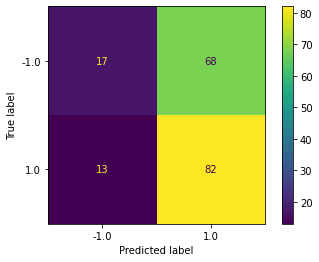

In [58]:
plot_confusion_matrix(clf, X_test_pca, y_test_bin)

In [59]:
y_pred = clf.predict(X_test_pca)

In [60]:
print('F1 score: '+str(f1_score(y_test_bin, y_pred, average='micro')))

F1 score: 0.55


In [64]:
np.unique(y_test_bin, return_counts=True)

(array([-1.,  1.]), array([85, 95], dtype=int64))

# Try something else

In [405]:
import keras
from keras import layers
from keras.optimizers import Adam

In [406]:
encoding_dim = 32

In [409]:
input_img = keras.Input(shape=(4644,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(4644, activation='sigmoid')(encoded)
autoencoder = keras.Model(input_img, decoded)
encoder = keras.Model(input_img, encoded)
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
customAdam = Adam(lr=0.001)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [410]:
autoencoder.fit(X_train, X_train, epochs=100, batch_size=50, shuffle=False, validation_data=(X_test, X_test))

Train on 720 samples, validate on 180 samples
Epoch 1/100
720/720 [==============================] - 1s 1ms/step - loss: 0.3867 - val_loss: -0.3301
Epoch 2/100
720/720 [==============================] - 0s 511us/step - loss: -1.2542 - val_loss: -2.0230
Epoch 3/100
720/720 [==============================] - 0s 366us/step - loss: -2.4340 - val_loss: -2.6804
Epoch 4/100
720/720 [==============================] - 0s 464us/step - loss: -2.9079 - val_loss: -3.0826
Epoch 5/100
720/720 [==============================] - 0s 654us/step - loss: -3.2697 - val_loss: -3.4257
Epoch 6/100
720/720 [==============================] - 0s 557us/step - loss: -3.5859 - val_loss: -3.7321
Epoch 7/100
720/720 [==============================] - 0s 556us/step - loss: -3.8765 - val_loss: -4.0190
Epoch 8/100
720/720 [==============================] - 0s 565us/step - loss: -4.1557 - val_loss: -4.2785
Epoch 9/100
720/720 [==============================] - 0s 405us/step - loss: -4.4066 - val_loss: -4.4873
Epoch 10/100

In [267]:
X_train_autoencoder = encoder.predict(X_train)

In [394]:
# Try some oversampling to combat the class imbalance
x_resampled, y_resampled = SMOTE().fit_resample(X_train_pca, y_train)
print(sorted(Counter(y_resampled).items()))

#x_resampled, y_resampled = RandomOverSampler().fit_resample(X_train_pca, y_train)
#print(sorted(Counter(y_resampled).items()))

[(-1.0, 625), (0.0, 625), (1.0, 625)]


In [395]:
#rf = RandomForestClassifier(random_state=1337)
rf = RandomForestClassifier(random_state=1337, criterion='entropy', max_depth=10, min_samples_split=15)
#ad = AdaBoostClassifier(random_state=1337)

In [396]:
#train best model
clf = rf.fit(x_resampled, y_resampled)

In [387]:
# HPO
## Random Forest ##
# parameters = {'max_depth':(10, 100), 'min_samples_split':[5, 15], 'criterion':['entropy','gini']}
# clf = GridSearchCV(rf, parameters)
# #clf.fit(X_train_pca, y_train_cat)
# #clf.fit(X_train,y_train_bin)
# clf.fit(x_resampled, y_resampled)
# print(clf.best_score_)
# print(clf.best_params_)

## AdaBoost ##
# parameters = {'n_estimators':[50, 100], 'learning_rate':[0.1, 1, 5]}
# clf = GridSearchCV(ad, parameters)
# #clf.fit(X_train_pca, y_train_bin)
# clf.fit(X_train_autoencoder, y_train_cat)

In [ ]:
# Transform target to 3 categories
# med_ids = np.where(np.logical_and(-1.5<y, y<1.5))[0]
# y[y>=1.5] = 1 
# y[y<=-1.5] = -1
# y[med_ids] = 0
# X = np.concatenate((X_tas,X_psl),axis=1)
# y=y.reshape(-1,1)